**Edric Tam Update Fatboy Report:**

1. Focus on spatial information. Take features 3 and 4, the distance and moment of inertia and get hierarchical clustering result. 
2. Obtained results that are what we would expect according to literature. 

In [1]:
# load all necessary dependencies and load in the log transformed data 
# for both integrated and local intensity

import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import pickle

from sklearn import cross_validation
from sklearn.cross_validation import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


N = 1000 # number of samples at each iteration

dataFile = open('local_processed.p')
localData = pickle.load(dataFile)
dataFile = open('integrated_processed.p')
integratedData = pickle.load(dataFile)
dataFile = open('distCenter_processed.p')
distData = pickle.load(dataFile)
dataFile = open('momentInertia_processed.p')
momData = pickle.load(dataFile)

/Users/saltpisces/Desktop/School/Genomics/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
markers = ['Synap','Synap','VGlut1','VGlut1','VGlut2','Vglut3',
              'psd','glur2','nmdar1','nr2b','gad','VGAT',
              'PV','Gephyr','GABAR1','GABABR','CR1','5HT1A',
              'NOS','TH','VACht','Synapo','tubuli','DAPI']

synapType = ['synap','synap','ex.pre','ex.pre','ex.pre','in.pre',
                  'ex.post','ex.post','ex.post','ex.post','in.pre','in.pre',
                  'in.pre','in.post','in.post','in.post','other','other',
                  'other','other','other','other','none','none']


# filter synapses such that only the ones with high synapsin expression will be accepted.
# add additional synapse filter so we include only those that have a high moment of inertia and large synapsin area 
avglocSynap1 = np.mean(localData[1])
avgintSynap1 = np.mean(integratedData[1])
avgdistSynap1 = np.mean(distData[1])
avgmomSynap1 = np.mean(momData[1])

intfilteredSynapse1 = [synapse for synapse, value in enumerate(integratedData[1]) if value > avgintSynap1]
locfilteredSynapse1 = [synapse for synapse, value in enumerate(localData[1]) if value > avglocSynap1]   
distfilteredSynapse1 = [synapse for synapse, value in enumerate(distData[1]) if value > avgdistSynap1]
momfilteredSynapse1 = [synapse for synapse, value in enumerate(momData[1]) if value > avgmomSynap1]   

highSynapsin1 = set(intfilteredSynapse1).intersection(locfilteredSynapse1)
highArea1 = set(distfilteredSynapse1).intersection(momfilteredSynapse1)

filteredSynapses1 = list(highSynapsin1.intersection(highArea1))

avglocSynap2 = np.mean(localData[2])
avgintSynap2 = np.mean(integratedData[2])
avgdistSynap2 = np.mean(distData[2])
avgmomSynap2 = np.mean(momData[2])

intfilteredSynapse2 = [synapse for synapse, value in enumerate(integratedData[2]) if value > avgintSynap2]
locfilteredSynapse2 = [synapse for synapse, value in enumerate(localData[2]) if value > avglocSynap2] 
distfilteredSynapse2 = [synapse for synapse, value in enumerate(distData[2]) if value > avgdistSynap2]
momfilteredSynapse2 = [synapse for synapse, value in enumerate(momData[2]) if value > avgmomSynap2]  

highSynapsin2 = set(intfilteredSynapse2).intersection(locfilteredSynapse2)
highArea2 = set(distfilteredSynapse2).intersection(momfilteredSynapse2)

filteredSynapses2 = list(set(intfilteredSynapse2).intersection(locfilteredSynapse2))

filteredSynapses = list(set(filteredSynapses1).intersection(filteredSynapses2))

# filter away synapses such that those with high tubulin expression will not be accepted

avgloctub = np.mean(localData[24])
avginttub = np.mean(integratedData[24])
avgdisttub = np.mean(distData[24])
avgmomtub = np.mean(momData[24])

intfilteredtub = [synapse for synapse, value in enumerate(integratedData[24]) if value < avginttub]
locfilteredtub = [synapse for synapse, value in enumerate(localData[24]) if value < avgloctub]
distfilteredtub = [synapse for synapse, value in enumerate(distData[24]) if value < avgdisttub]
momfilteredtub = [synapse for synapse, value in enumerate(momData[24]) if value < avgmomtub]  

areafilteredtub = list(set(distfilteredtub).intersection(momfilteredtub))

intensityfilteredtub = list(set(intfilteredtub).intersection(locfilteredtub))

finaltubFiltered = list(set(intensityfilteredtub).intersection(areafilteredtub))


finalFilteredInd = list(set(finaltubFiltered).intersection(filteredSynapses))

# now that we have the valid synapses, we only want certain features...
# i.e. the inhibitory and the excitatory ones

exAndInMarkerInd = [i for i,j in enumerate(synapType) if j[0:2] == 'in' or j[0:2]=='ex']
otherMarkerInd = [i for i,j in enumerate(synapType) if j[0:5] == 'other' or j[0:5 == 'Synap']]

# finalized filtered data
exAndInIntData =  np.asarray([integratedData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
exAndInLocData =  np.asarray([localData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
exAndInDistData =  np.asarray([distData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))
exAndInMomData =  np.asarray([momData[i][q] for i in exAndInMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(exAndInMarkerInd))

otherIntData =  np.asarray([integratedData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))
otherLocData =  np.asarray([localData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))
otherDistData =  np.asarray([distData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))
otherMomData =  np.asarray([momData[i][q] for i in otherMarkerInd \
                               for q in finalFilteredInd]).reshape(len(finalFilteredInd),len(otherMarkerInd))


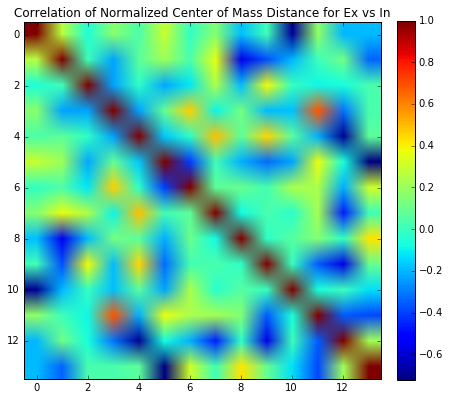

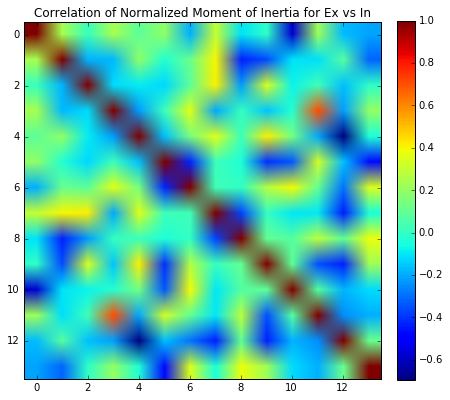

In [4]:
np.random.seed(1)  # for reproducibility, set random seed
randPermute = np.random.permutation(range(0,len(finalFilteredInd)))
randSample = randPermute[0:N]

exAndInLocFeatures = exAndInLocData[randSample,:]
exAndInIntFeatures = exAndInIntData[randSample,:]
exAndInDistFeatures = exAndInDistData[randSample,:]
exAndInMomFeatures = exAndInMomData[randSample,:]

otherLocFeatures = otherLocData[randSample,:]
otherIntFeatures = otherIntData[randSample,:]
otherDistFeatures = otherDistData[randSample,:]
otherMomFeatures = otherMomData[randSample,:]

rExAndIn = len(exAndInMarkerInd)
rOther = len(otherMarkerInd)

%matplotlib inline


exAndInCorrDist = np.empty([rExAndIn,rExAndIn])
for i in range(0,rExAndIn):
    for j in range(0,rExAndIn):
        results = np.corrcoef(exAndInDistFeatures[i,:],exAndInDistFeatures[j,:])
        exAndInCorrDist[i,j] = results[1,0]

plt.figure(figsize=(7,7))
im = plt.imshow(exAndInCorrDist)
plt.title('Correlation of Normalized Center of Mass Distance for Ex vs In')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()

exAndInCorrMom = np.empty([rExAndIn,rExAndIn])
for i in range(0,rExAndIn):
    for j in range(0,rExAndIn):
        results = np.corrcoef(exAndInMomFeatures[i,:],exAndInMomFeatures[j,:])
        exAndInCorrMom[i,j] = results[1,0]

plt.figure(figsize=(7,7))
im = plt.imshow(exAndInCorrMom)
plt.title('Correlation of Normalized Moment of Inertia for Ex vs In')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.show()



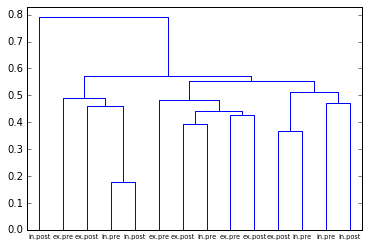

In [5]:
import hcluster
import scipy.cluster.hierarchy as sch
markerlabels = [markers[i] for i in exAndInMarkerInd]
typelabels = [synapType[i] for i in exAndInMarkerInd]
Z=sch.linkage(exAndInCorrMom, 'single', 'correlation')
localDendro = sch.dendrogram(Z, color_threshold=0, labels=typelabels,leaf_font_size=6.5)

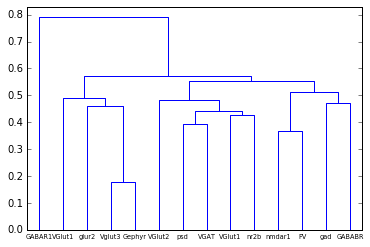

In [6]:
Z=sch.linkage(exAndInCorrMom, 'single', 'correlation')
localDendro = sch.dendrogram(Z, color_threshold=0, labels=markerlabels,leaf_font_size=6.5)

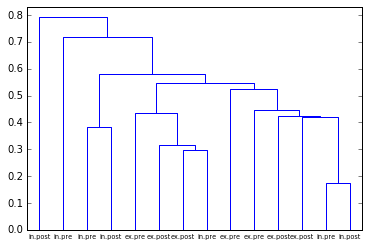

In [7]:
Z=sch.linkage(exAndInCorrDist, 'single', 'correlation')
localDendro = sch.dendrogram(Z, color_threshold=0, labels=typelabels,leaf_font_size=6.5)

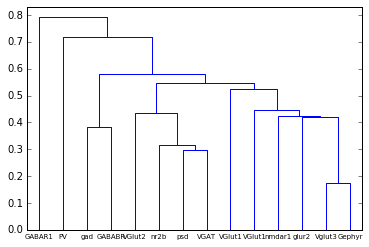

In [11]:
Z=sch.linkage(exAndInCorrDist, 'single', 'correlation')
localDendro = sch.dendrogram(Z, color_threshold=0, labels=markerlabels,leaf_font_size=7)

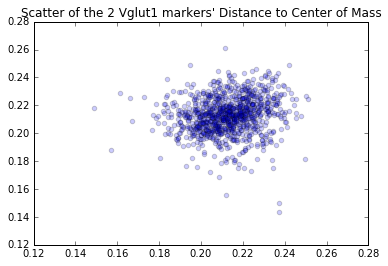

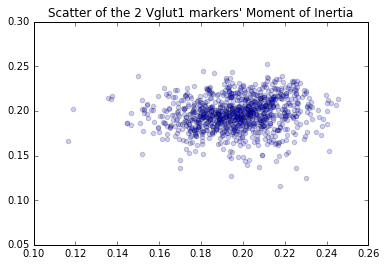

In [12]:
firstVGlutDist = exAndInDistData[randSample,0]
firstVGlutMom = exAndInMomData[randSample,0]

secondVGlutDist = exAndInDistData[randSample,1]
secondVGlutMom = exAndInMomData[randSample,1]


plt.scatter(firstVGlutDist, secondVGlutDist,alpha=0.2)
plt.title("Scatter of the 2 Vglut1 markers' Distance to Center of Mass")
plt.show()
plt.scatter(firstVGlutMom, secondVGlutMom,alpha=0.2)
plt.title("Scatter of the 2 Vglut1 markers' Moment of Inertia")
plt.show()